In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#train_data = pd.read_csv('/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_train.csv')
#train_data_new = train_data[train_data['body'].notnull()]

#test_data = pd.read_csv("/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_test.csv")
#test_data_new = test_data[test_data['body'].notnull()]

data = pd.read_csv("/content/drive/MyDrive/YL/metin_madenciligi_proje/preprocessed_european_comments.csv")

In [ ]:
data.head()

,Unnamed: 0,body,Subjectivity,Polarity,Analysis
0,0,"woman claims said insults, bystanders didnt. t...",0.843750,-0.322917,Negative
1,1,turkey doesn't know balkans.,0.000000,0.000000,Neutral
2,2,lot talk turkey,0.000000,0.000000,Neutral
3,3,don't like ruling party turkey. it's turkish p...,0.000000,0.000000,Neutral
4,4,create confusion absolute numbers. ~0.01 popul...,0.423384,-0.020833,Negative


In [ ]:
#combined_data = train_data.append(test_data, ignore_index=True)
data.shape

(71820, 5)

In [ ]:
data["Analysis"].value_counts()

Positive    34026
Negative    21331
Neutral     16463
Name: Analysis, dtype: int64

In [ ]:
tokenized_data = data['body'].apply(lambda x: str(x).split()) # tokenizing

In [ ]:
tokenized_data

0        [woman, claims, said, insults,, bystanders, di...
1                        [turkey, doesn't, know, balkans.]
2                                      [lot, talk, turkey]
3        [don't, like, ruling, party, turkey., it's, tu...
4        [create, confusion, absolute, numbers., ~0.01,...
                               ...                        
71815    [reiterate., better, fuck, rights, 500, people...
71816    [term, broad., prefer, term, near, east, short...
71817    [actually, georgians, tao-klarjeti., artvin, a...
71818    [genocide, equivalent, person, intentionally, ...
71819    [agree, turkey, europe,, suppose, people, euro...
Name: body, Length: 71820, dtype: object

In [ ]:
from gensim.models import Word2Vec

In [ ]:
model_w2v = Word2Vec(tokenized_data, size=256,  window=5)
model_w2v.train(tokenized_data, total_examples= len(tokenized_data), epochs=10)

(25430528, 28743220)

In [ ]:
model_w2v.wv.most_similar(positive="ottoman")

[('turkey/ottoman', 0.6983129978179932),
 ('austro-hungarian', 0.6777205467224121),
 ('otoman', 0.6688921451568604),
 ('byzantine', 0.6556719541549683),
 ('achaemenid', 0.620552122592926),
 ('"ottoman', 0.6180290579795837),
 ('roman', 0.5874354839324951),
 ('byzantium', 0.5773022174835205),
 ('lebensraum', 0.535973310470581),
 ('(ottoman', 0.5358951687812805)]

In [ ]:
# EEZ: Exclusive Economic Zone (Münhasır Ekonomik Bölge)
model_w2v.wv.most_similar(positive="eez")

[('eez.', 0.7852843403816223),
 ('eez,', 0.7524026036262512),
 ('kastellorizo', 0.7447876930236816),
 ('12nm', 0.6910964250564575),
 ('kastelorizo', 0.6875766515731812),
 ('eez?', 0.6668062806129456),
 ('rhodes', 0.6421265602111816),
 ('aegean.', 0.6225293874740601),
 ('meis', 0.6224466562271118),
 ('eezs.', 0.6219027042388916)]

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_data), 256))

for i in range(len(data)):
    wordvec_arrays[i,:] = word_vector(tokenized_data[i], 256)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(71820, 256)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#train_w2v = wordvec_df.iloc[:56819,:]
#test_w2v = wordvec_df.iloc[56819:,:]

X_train, x_test, y_train, y_valid = train_test_split(wordvec_df, data['Analysis'],  
                                                          random_state=42, 
                                                          test_size=0.2)

#print(train_w2v.shape, data['Analysis'].shape)

#xtrain_w2v = train_w2v.iloc[y_train.index,:]
#xvalid_w2v = train_w2v.iloc[y_valid.index,:]

In [ ]:
X_train.shape

(57456, 256)

In [ ]:
x_test.shape

(14364, 256)

In [ ]:
y_train.shape

(57456,)

In [ ]:
y_train

48535    Positive
67023     Neutral
26792     Neutral
52        Neutral
68065     Neutral
           ...   
37194    Negative
6265     Positive
54886    Negative
860      Negative
15795    Positive
Name: Analysis, Length: 57456, dtype: object

In [ ]:
y_valid.shape

(14364,)

In [ ]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_valid)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [ ]:
train_labels

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
test_labels.shape

(14364, 3)

In [ ]:
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from keras import models
import keras.losses

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Embedding,Dense,Flatten
from tensorflow.keras.metrics import AUC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

epochs = 50
batch_size = 256
optimizer = "adam"
metrics = ["categorical_crossentropy", AUC(name='auc')]

# Build neural network
model = models.Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics= metrics)

history = model.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(x_test, test_labels))

Epoch 1/50
225/225 [==============================] - 3s 8ms/step - loss: 0.8795 - categorical_crossentropy: 0.8795 - auc: 0.7685 - val_loss: 0.8011 - val_categorical_crossentropy: 0.8011 - val_auc: 0.8139
Epoch 2/50
225/225 [==============================] - 1s 5ms/step - loss: 0.7828 - categorical_crossentropy: 0.7828 - auc: 0.8226 - val_loss: 0.7736 - val_categorical_crossentropy: 0.7736 - val_auc: 0.8279
Epoch 3/50
225/225 [==============================] - 1s 5ms/step - loss: 0.7584 - categorical_crossentropy: 0.7584 - auc: 0.8340 - val_loss: 0.7556 - val_categorical_crossentropy: 0.7556 - val_auc: 0.8363
Epoch 4/50
225/225 [==============================] - 1s 5ms/step - loss: 0.7447 - categorical_crossentropy: 0.7447 - auc: 0.8406 - val_loss: 0.7497 - val_categorical_crossentropy: 0.7497 - val_auc: 0.8389
Epoch 5/50
225/225 [==============================] - 1s 5ms/step - loss: 0.7345 - categorical_crossentropy: 0.7345 - auc: 0.8447 - val_loss: 0.7485 - val_categorical_crossentr

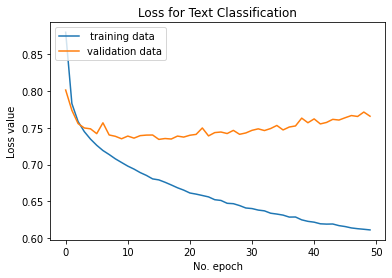

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

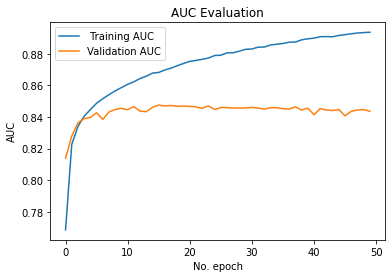

In [ ]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
y__pred = model.predict(x_test)


In [ ]:
y__pred.shape

(14364, 3)

In [ ]:
y__pred = np.where((y__pred == 0),'Negative', y__pred)
y__pred = np.where((y__pred == '1'),'Neutral', y__pred)
y__pred = np.where((y__pred == '2'),'Positive', y__pred)

In [ ]:
y_valid.shape

(14364,)

In [ ]:
print(classification_report(data.Analysis, y__pred))

ValueError: ignored